<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lorenz-trajectory" data-toc-modified-id="Lorenz-trajectory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lorenz trajectory</a></span><ul class="toc-item"><li><span><a href="#CV-predictions" data-toc-modified-id="CV-predictions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>CV predictions</a></span><ul class="toc-item"><li><span><a href="#plot-errors" data-toc-modified-id="plot-errors-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>plot errors</a></span></li><li><span><a href="#compare-NP-sets" data-toc-modified-id="compare-NP-sets-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>compare NP sets</a></span></li></ul></li><li><span><a href="#Check-gpu" data-toc-modified-id="Check-gpu-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check gpu</a></span><ul class="toc-item"><li><span><a href="#Cluster" data-toc-modified-id="Cluster-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Cluster</a></span></li><li><span><a href="#Quantile" data-toc-modified-id="Quantile-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Quantile</a></span></li><li><span><a href="#heal" data-toc-modified-id="heal-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>heal</a></span></li><li><span><a href="#Heal-test" data-toc-modified-id="Heal-test-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Heal test</a></span></li></ul></li></ul></li></ul></div>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

In [2]:
from src.Lorentz import Lorentz
from src.TSProcessor_GPU import TSProcessor

%load_ext autoreload
%autoreload 2

In [3]:
from src.utils import normalize, denormalize, gen_sin_wave, plot_trajectories, plot_runs
from copy import deepcopy

In [4]:
import torch
import gc
import pickle

## Lorenz trajectory

### CV predictions

In [5]:
train_size = 1000
h_max = 100 # max prediction horizon (t+h)
n_folds = 500


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.2
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

assert n_trajectories*(1-2*alpha) > min_trajectories

In [6]:
x, _, _ = Lorentz().generate(0.1, 3000+n_folds*(train_size+h_max)-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [7]:
runs = {
    'single': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'priori': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_quantile': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_healing': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_template_healing': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
}

In [8]:
# runs = pickle.load( open( "runs.p", "rb" ) )

In [9]:
# runs['unified_template_healing'] = {
#         'rmse': np.zeros((n_folds, h_max)),
#         'non_pred': np.zeros((n_folds, h_max)),
# }

In [11]:
# priori and single
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size].copy()
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size].copy()
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max].copy()
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    

    # priori
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        use_priori=True,
        X_test=X_test,
        priori_eps=priori_eps,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        use_priori=True,
        X_test=X_test_cpu,
        priori_eps=priori_eps,
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['priori']['rmse'][fold] = rmse
    runs['priori']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # single
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=1,
        noise_amp=0,
        use_priori=False,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    X_pred = X_traj_pred[:, 0]
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['single']['rmse'][fold] = rmse
    runs['single']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
# unified and unified_quantile
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size]
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max]
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    
    # unified
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified']['rmse'][fold] = rmse
    runs['unified']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # unified_quantile
    
    # reusing X_traj_pred from previoius step
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='quantile',
        alpha=alpha,
        max_err=max_err,
        min_trajectories=min_trajectories,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified_quantile']['rmse'][fold] = rmse
    runs['unified_quantile']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
# healing
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size]
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max]
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    
    # healing
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        X_pred=X_pred,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        X_pred=X_pred,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    gc.collect()
    torch.cuda.empty_cache()
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified_healing']['rmse'][fold] = rmse
    runs['unified_healing']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
# template healing
for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')
    
    start_points = max_template_spread * (points_in_template-1)
    
    X_start = x[t+train_size-start_points:t+train_size]
    X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')
    
    X_test_cpu = x[t+train_size:t+train_size+h_max]
    X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread,
        X_train=X_train,
    )
    
    # unified
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    X_pred = torch.from_numpy(X_pred).to('cuda')
    
    gc.collect()
    torch.cuda.empty_cache()
    
    X_traj_pred = tsp.heal(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        X_pred=X_pred,
        random_seed=1
    )
    X_traj_pred = X_traj_pred.cpu().numpy()
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test_cpu)**2
    runs['unified_template_healing']['rmse'][fold] = rmse
    runs['unified_template_healing']['non_pred'][fold] = non_pred
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

#### plot errors

In [14]:
# pickle.dump(runs, open( "runs.p", "wb" ) )

In [9]:
runs_processed = deepcopy(runs)
for method in runs_processed.keys():
    rmses = runs_processed[method]['rmse']
    non_preds = runs_processed[method]['non_pred']
    non_preds = 100*non_preds.sum(axis=0) / non_preds.shape[0]
    # might be bogged
    # np.sqrt(np.nan_to_num(rmses / (rmses.shape[0] - np.isnan(rmses).sum(axis=0))).sum(axis=0))
    rmses = np.sqrt(np.nanmean(rmses, axis=0))
    runs_processed[method]['rmse'] = rmses
    runs_processed[method]['non_pred'] = non_preds

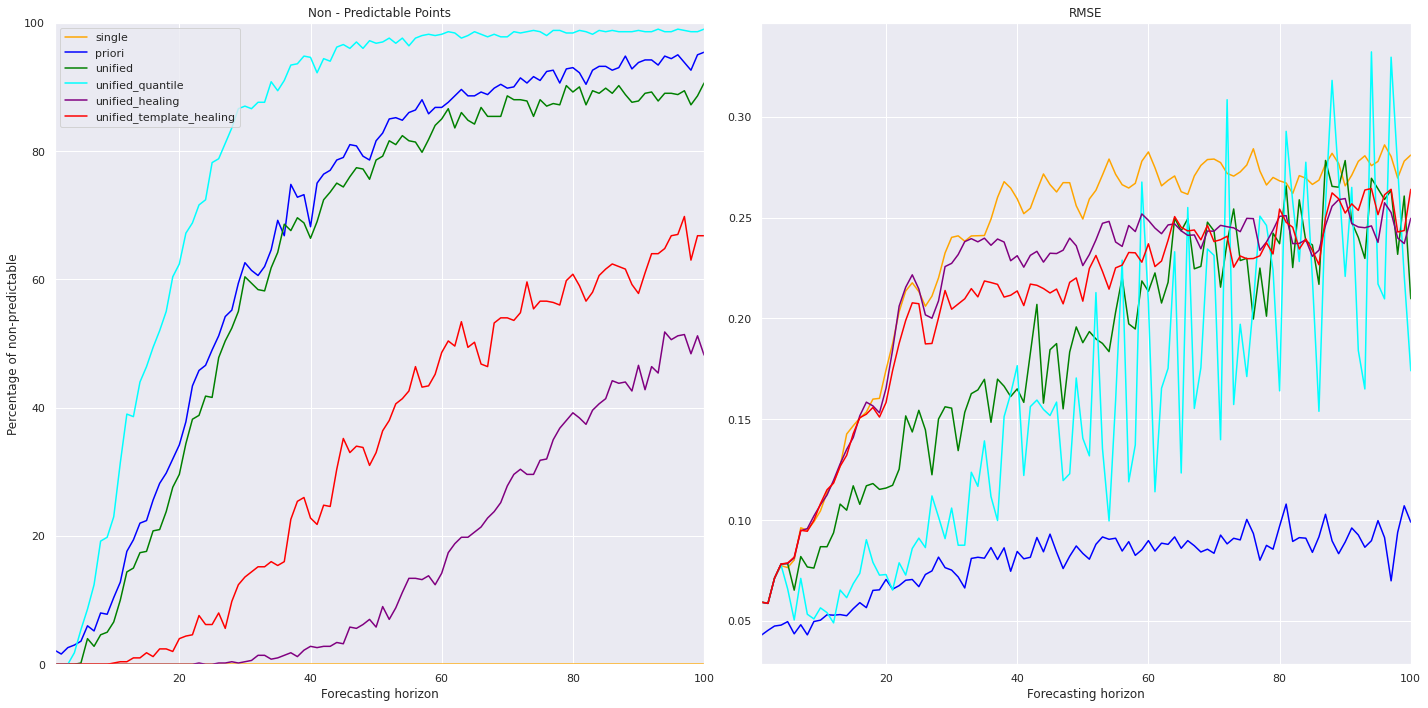

In [10]:
plot_runs(runs_processed, h_max, filename=f'images/fig4_healing_{h_max}_{noise_amp:.3f}.png')

In [11]:
tmp = []
for method in runs.keys():
    rmse = runs[method]['rmse']
    rmses = np.sqrt(np.nanmean(rmse, axis=0))
    tmp += [(method, i+1, rmses[i]) for i in range(len(rmses))]

runs_df = pd.DataFrame(tmp, columns=['method', 'step', 'rmse'])

In [12]:
runs_df.to_csv('runs.csv')

In [13]:
diff = (runs_df[runs_df['method'] == 'unified_healing']['rmse'].to_numpy() -
 runs_df[runs_df['method'] == 'unified']['rmse'].to_numpy())

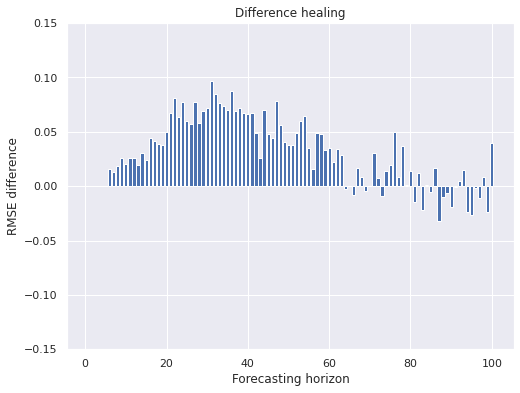

In [14]:
fig = plt.figure(figsize=(8, 6))

plt.title('Difference healing')
plt.bar(range(1, len(diff)+1), diff)
plt.xlabel('Forecasting horizon');
plt.ylabel('RMSE difference');
plt.ylim(-0.15, 0.15)

fig.savefig('images/healing_improvement.png')

In [15]:
diff = (runs_df[runs_df['method'] == 'unified_healing']['rmse'].to_numpy() -
 runs_df[runs_df['method'] == 'unified_template_healing']['rmse'].to_numpy())

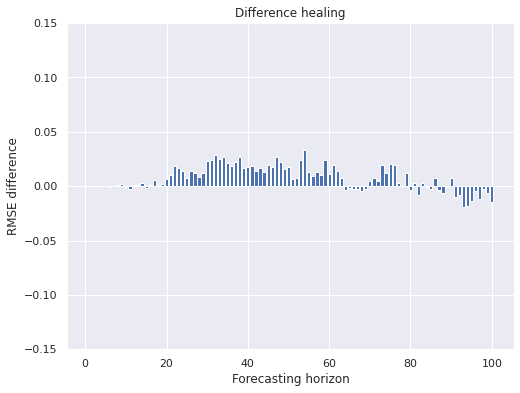

In [16]:
fig = plt.figure(figsize=(8, 6))

plt.title('Difference healing')
plt.bar(range(1, len(diff)+1), diff)
plt.xlabel('Forecasting horizon');
plt.ylabel('RMSE difference');
plt.ylim(-0.15, 0.15)

fig.savefig('images/healing_improvement_template.png')

#### compare NP sets

In [109]:
tmp = []
for method in runs.keys():
    rmse = runs[method]['rmse']
    rmses = np.sqrt(np.nanmean(rmse, axis=0))
    tmp += [(method, i+1, rmses[i]) for i in range(len(rmses))]

runs_df = pd.DataFrame(tmp, columns=['method', 'step', 'rmse'])

In [36]:
gtnp = runs['priori']['non_pred']

In [129]:
def get_sets_df(non_pred):
    gtnp_diffs = []
    npgt_diffs = []
    symm_diffs = []

    for fold in range(n_folds):
        np_set = set(np.where(non_pred[fold] == 1)[0])
        gtnp_set = set(np.where(gtnp[fold] == 1)[0])
        gtnp_diffs.append(len(gtnp_set.difference(np_set)))
        npgt_diffs.append(len(np_set.difference(gtnp_set)))
        symm_diffs.append(len(np_set.symmetric_difference(gtnp_set)))
        
    np_sets_df = pd.DataFrame(
        np.array([gtnp_diffs, npgt_diffs, symm_diffs]).T,
        columns=['gtnp_diff', 'npgt_diff', 'symm_diff'])
    np_sets_df['gtnp_diff'] = np_sets_df['gtnp_diff'] / np_sets_df['symm_diff']
    np_sets_df['npgt_diff'] = np_sets_df['npgt_diff'] / np_sets_df['symm_diff']

    return np_sets_df

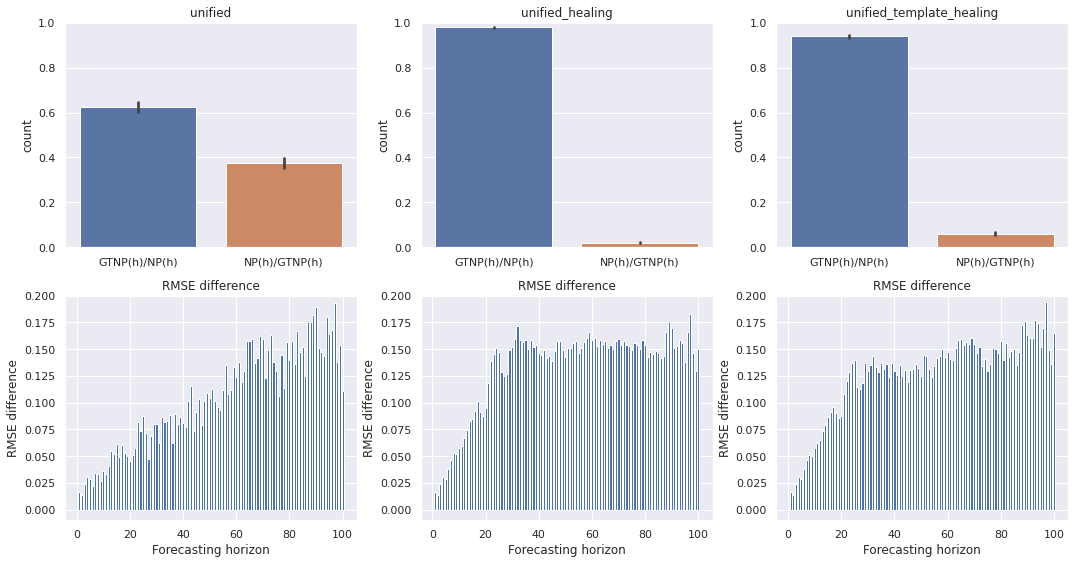

In [132]:
fig = plt.figure(figsize=[15, 8])

methods = ['unified', 'unified_healing', 'unified_template_healing']
for i, method in enumerate(methods):
    non_pred = runs[method]['non_pred']
    np_sets_df = get_sets_df(non_pred)
    
    
    np_sets_df = np_sets_df.melt(value_vars=['gtnp_diff', 'npgt_diff'])
    np_sets_df['variable'] = np_sets_df['variable'] \
        .map({'gtnp_diff': 'GTNP(h)/NP(h)', 'npgt_diff': 'NP(h)/GTNP(h)'})
    plt.subplot(2, 3, i+1)
    ax = sns.barplot(
        x="variable", y="value", estimator=np.mean,
        data=np_sets_df)
    
    ax.set_ylim((0, 1))
    ax.set_title(method)
    ax.set_xlabel('')
    ax.set_ylabel('count')
    
    diff = (runs_df[runs_df['method'] == method]['rmse'].to_numpy() -
     runs_df[runs_df['method'] == 'priori']['rmse'].to_numpy())
    
    plt.subplot(2, 3, i+4)
    plt.title('RMSE difference')
    plt.bar(range(1, len(diff)+1), diff)
    plt.xlabel('Forecasting horizon');
    plt.ylabel('RMSE difference');
    plt.ylim(-0.01, 0.2)

fig.tight_layout()
fig.savefig('images/GTNP_comparison.png')

### Check gpu

In [ ]:
train_size = 1000
h_max = 100 # max prediction horizon (t+h)
n_folds = 500


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.2
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

assert n_trajectories*(1-2*alpha) > min_trajectories

In [ ]:
x, _, _ = Lorentz().generate(0.1, 3000+n_folds*(train_size+h_max)-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [ ]:
fold = 0
t = (train_size+h_max) * fold

X_train = x[t:t+train_size]
X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')

start_points = max_template_spread * (points_in_template-1)

X_start = x[t+train_size-start_points:t+train_size]
X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')

X_test_cpu = x[t+train_size:t+train_size+h_max]
X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')


tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread,
    X_train=X_train,
)

#### Cluster

In [ ]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=X_test,
    priori_eps=priori_eps,
    random_seed=1
)

In [ ]:
X_traj_pred = X_traj_pred.cpu().numpy()

In [ ]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

In [ ]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

#### Quantile

In [ ]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='quantile',
    use_priori=False,
    min_trajectories=min_trajectories,
    max_err=max_err,
    alpha=alpha,
)
X_pred = unified_result['X_pred']
qs = unified_result['qs']
traj_alive = unified_result['traj_alive']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

In [ ]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

In [ ]:
# quantile plot

fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test_cpu, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.fill_between(range(len(qs)), qs[:, 0], qs[:, 1], alpha=0.3)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive),
           color='orange', label='min_trajectories')
plt.legend()
plt.ylim(0, n_trajectories);

#### heal

In [ ]:
fold = 0
t = (train_size+h_max) * fold

X_train = x[t:t+train_size]
X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')

start_points = max_template_spread * (points_in_template-1)

X_start = x[t+train_size-start_points:t+train_size]
X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')

X_test_cpu = x[t+train_size:t+train_size+h_max]
X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')


tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread,
    X_train=X_train,
)

In [ ]:
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=X_test,
    priori_eps=priori_eps,
    random_seed=1
)

In [ ]:
X_traj_pred = X_traj_pred.cpu().numpy()

In [ ]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

In [ ]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

In [ ]:
X_pred = torch.from_numpy(X_pred).to('cuda')

In [ ]:
X_test[88]

In [ ]:
X_traj_pred = tsp.heal(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    X_pred=X_pred,
    random_seed=1
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
X_traj_pred = X_traj_pred.cpu().numpy()

In [ ]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

In [ ]:
plot_trajectories(
    'Lorenz', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

#### Heal test

In [ ]:
train_size = 50
h_max = 20 # max prediction horizon (t+h)
n_folds = 500


points_in_template = 3
max_template_spread = 2 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01

In [ ]:
x = np.concatenate([
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
    np.array(range(20)),
    np.array(range(18, 0, -1)),
])

In [ ]:
t=0
X_train = x[t:t+train_size]
X_train = torch.from_numpy(X_train).type(torch.float32).to('cuda')

start_points = max_template_spread * (points_in_template-1)

X_start = x[t+train_size-start_points:t+train_size]
X_start = torch.from_numpy(X_start).type(torch.float32).to('cuda')

X_test_cpu = x[t+train_size:t+train_size+h_max]
X_test = torch.from_numpy(X_test_cpu).type(torch.float32).to('cuda')

tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread,
    X_train=X_train,
)

In [ ]:
X_pred = X_test.clone()
X_pred[0] = np.nan
X_pred[6] = np.nan
X_pred[10] = np.nan

In [ ]:
X_test

In [ ]:
X_traj_pred = tsp.heal(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    X_pred=X_pred,
    random_seed=1
)

In [ ]:
X_traj_pred = X_traj_pred.cpu().numpy()

In [ ]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test_cpu)**2

gc.collect()
torch.cuda.empty_cache()

In [ ]:
plot_trajectories(
    'random', X_train.cpu().numpy(), X_test.cpu().numpy(), # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred#, filename=f'Lorenz_cluster_{fold}_{noise_amp:.2f}.png'
)

In [ ]:
X_traj_pred = tsp.heal(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    X_pred=X_pred,
    random_seed=1
)